In [18]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [19]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/UserAccessEditandDeletion/UserType.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [20]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [21]:
data.head()

,Clause,Category
0,Correcting Information You are responsible...,[Unspecified]
1,log into your account and follow the instructions,[User with account]
2,log into your account,[User with account]
3,You can jump to specific areas of our Privacy ...,[not-selected]
4,Your Options To manage and correct any fac...,"[Unspecified, not-selected]"


In [22]:
classes_dict.head()

,Unspecified,User with account,not-selected,Other,User without account
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0


In [23]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [24]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [25]:
df.columns.values[2:]

array(['Unspecified', 'User with account', 'not-selected', 'Other',
       'User without account'], dtype=object)

# Visualizing Data

In [26]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Unspecified,109.0
1,User with account,122.0
2,not-selected,42.0
3,Other,22.0
4,User without account,8.0


Text(0.5, 0, 'category')

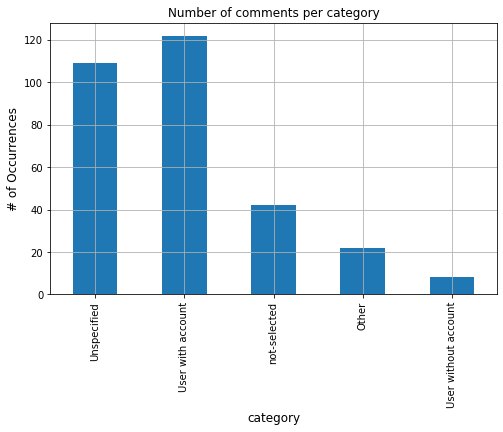

In [27]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [28]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [29]:
x_test = test.Clause
x_train = train.Clause

In [30]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [31]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<289x1435 sparse matrix of type '<class 'numpy.float64'>'
	with 7256 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [32]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.6379310344827587
... Processing User with account
Test accuracy is 0.896551724137931
... Processing not-selected
Test accuracy is 0.7931034482758621
... Processing Other
Test accuracy is 1.0
... Processing User without account
Test accuracy is 0.9827586206896551


array([[[25,  8],
        [13, 12]],

       [[37,  0],
        [ 6, 15]],

       [[46,  0],
        [12,  0]],

       [[58,  0],
        [ 0,  0]],

       [[57,  0],
        [ 1,  0]]], dtype=int64)

# Linear SVC

In [33]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.7241379310344828
... Processing User with account
Test accuracy is 0.896551724137931
... Processing not-selected
Test accuracy is 0.8275862068965517
... Processing Other
Test accuracy is 0.9655172413793104
... Processing User without account
Test accuracy is 0.9827586206896551


array([[[24,  9],
        [ 7, 18]],

       [[35,  2],
        [ 4, 17]],

       [[46,  0],
        [10,  2]],

       [[56,  2],
        [ 0,  0]],

       [[57,  0],
        [ 1,  0]]], dtype=int64)

# Logistic Regression

In [34]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Unspecified
Test accuracy is 0.6896551724137931
... Processing User with account
Test accuracy is 0.9137931034482759
... Processing not-selected
Test accuracy is 0.7931034482758621
... Processing Other
Test accuracy is 1.0
... Processing User without account
Test accuracy is 0.9827586206896551


array([[[25,  8],
        [10, 15]],

       [[37,  0],
        [ 5, 16]],

       [[46,  0],
        [12,  0]],

       [[58,  0],
        [ 0,  0]],

       [[57,  0],
        [ 1,  0]]], dtype=int64)

In [35]:
import pickle
#saving model
list_of_classifiers = classifier_list_svc
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=